# Simulator

In this section we will show how to use the `a2rl.Simulator` to get a recommendation.

The way Simulator provides recommendation is different from a typical Reinforcement Learning approach, where you need to first train a RL agent (e.g. SAC, PPO) with a simulator, then only the agent can recommend an action.

First a Q-value has been calculated internally when you load the data using `wi_df.add_value()`. Then the Simulator is trained with sequences of states, actions, rewards, Q-value. In order to choose an action, you just need to sample multiple trajectory based on the current context.


In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import my_nb_path  # isort: skip
import os
from pathlib import Path

import numpy as np

import a2rl as wi
from a2rl.nbtools import pprint, print  # Enable color outputs when rich is installed.

/opt/hostedtoolcache/Python/3.10.11/x64/lib/python3.10/site-packages/lightning_fabric/__init__.py:36: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('lightning_fabric')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references/keywords.html#keyword-namespace-packages
  __import__("pkg_resources").declare_namespace(__name__)


/opt/hostedtoolcache/Python/3.10.11/x64/lib/python3.10/site-packages/pytorch_lightning/__init__.py:36: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('pytorch_lightning')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references/keywords.html#keyword-namespace-packages
  __import__("pkg_resources").declare_namespace(__name__)
/opt/hostedtoolcache/Python/3.10.11/x64/lib/python3.10/site-packages/nptyping/typing_.py:51: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  Bool8 = np.bool8
/opt/hostedtoolcache/Python/3.10.11/x64/lib/python3.10/site-packages/nptyping/typing_.py:54: DeprecationWarning: `np.object0` is a deprecated alias for ``np.object0` is a deprecated alias for `np.object_`. `object` can be used instead.  (Deprecated NumPy 1.24)`.  (Deprecated NumPy 1.24)
  Object0 = np.object0
/opt/hostedtoolc

## Load Dataset

Instantiate a tokenizer given the selected dataset.

In [2]:
wi_df = wi.read_csv_dataset(wi.sample_dataset_path("chiller"))
wi_df.add_value()

# Speed up training for demo purpose
wi_df = wi_df.iloc[:1000]
tokenizer = wi.AutoTokenizer(wi_df, block_size_row=2)

tokenizer.df.head(2)

/opt/hostedtoolcache/Python/3.10.11/x64/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:279: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(


/opt/hostedtoolcache/Python/3.10.11/x64/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:279: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(


condenser_inlet_temp  evaporator_heat_load_rt staging   
0                  29.5                    455.4       1  \
1                  30.2                    913.1       0   

   system_power_consumption        value  
0                     756.4  1007.294795  
1                     959.3   780.987943

In [3]:
tokenizer.df_tokenized.head(2)

condenser_inlet_temp  evaporator_heat_load_rt  staging   
0                    26                       45      344  \
1                    33                      104      343   

   system_power_consumption  value  
0                       173    300  
1                       213    261

## Train a model

Default hyperparam is located at `src/a2rl/config.yaml`. Alternative you can (1) specify your own configuration file using `config_dir` and `config_name`, or (2) passing in the configuration as parameter `config`. Refer to `GPTBuilder` for more info.

In [4]:
model_dir = "model-simulator"
config = None  # Default training configuration

################################################################################
# To run in fast mode, set env var NOTEBOOK_FAST_RUN=1 prior to starting Jupyter
################################################################################
if os.environ.get("NOTEBOOK_FAST_RUN", "0") != "0":
    config = {
        "train_config": {
            "epochs": 1,
            "batch_size": 512,
            "embedding_dim": 512,
            "gpt_n_layer": 1,
            "gpt_n_head": 1,
            "learning_rate": 6e-4,
            "num_workers": 0,
            "lr_decay": True,
        }
    }

    from IPython.display import Markdown

    display(
        Markdown(
            '<p style="color:firebrick; background-color:yellow; font-weight:bold">'
            "NOTE: notebook runs in fast mode. Use only 1 epoch. Results may differ."
        )
    )
################################################################################
builder = wi.GPTBuilder(tokenizer, model_dir, config)

<p style="color:firebrick; background-color:yellow; font-weight:bold">NOTE: notebook runs in fast mode. Use only 1 epoch. Results may differ.

Start GPT model training.

In [5]:
%%time
builder.fit()

2023-05-22 10:08:55.525 | INFO     | a2rl.simulator:fit:753 - {'epochs': 1, 'batch_size': 512, 'embedding_dim': 512, 'gpt_n_layer': 1, 'gpt_n_head': 1, 'learning_rate': 0.0006, 'num_workers': 0, 'lr_decay': True}


  0%|          | 0/10 [00:00<?, ?it/s]

2023-05-22 10:09:00.403 | INFO     | a2rl.simulator:fit:787 - Training time in mins: 0.08


CPU times: user 9.12 s, sys: 351 ms, total: 9.47 s
Wall time: 4.9 s


GPT(
  (tok_emb): Embedding(351, 512)
  (drop): Dropout(p=0.1, inplace=False)
  (blocks): Sequential(
    (0): Block(
      (ln1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      (ln2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      (attn): CausalSelfAttention(
        (key): Linear(in_features=512, out_features=512, bias=True)
        (query): Linear(in_features=512, out_features=512, bias=True)
        (value): Linear(in_features=512, out_features=512, bias=True)
        (attn_drop): Dropout(p=0.1, inplace=False)
        (resid_drop): Dropout(p=0.1, inplace=False)
        (proj): Linear(in_features=512, out_features=512, bias=True)
      )
      (mlp): Sequential(
        (0): Linear(in_features=512, out_features=2048, bias=True)
        (1): GELU(approximate='none')
        (2): Linear(in_features=2048, out_features=512, bias=True)
        (3): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (ln_f): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
  (

Plot the original GPT token vs predicted horizon given initial context window.

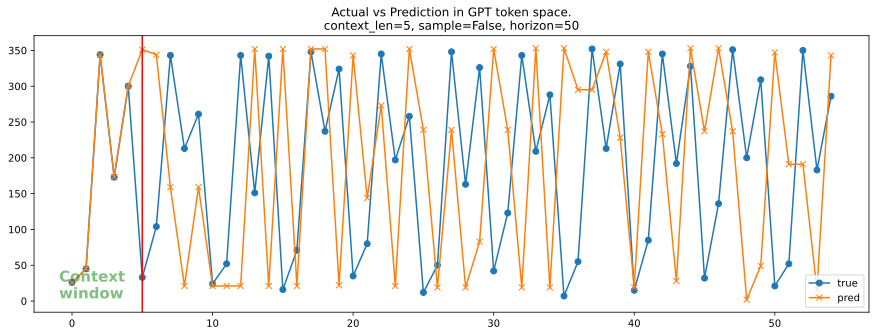

In [6]:
builder.evaluate(context_len=5, sample=False, horizon=50);

The graph above is like behaviour cloning. The model will active according to historical pattern. In the next graph, you can sample different trajectory when `sample=True`.

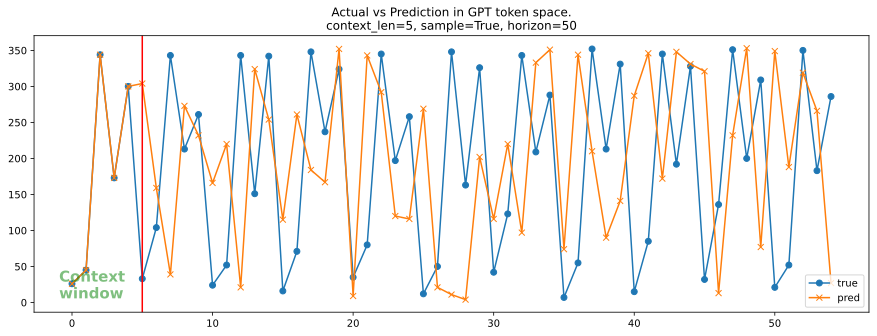

In [7]:
builder.evaluate(context_len=5, sample=True, horizon=50);

## Get Recommendation



In [8]:
simulator = wi.Simulator(tokenizer, builder.model)
simulator.tokenizer.df_tokenized.head(2)

condenser_inlet_temp  evaporator_heat_load_rt  staging   
0                    26                       45      344  \
1                    33                      104      343   

   system_power_consumption  value  
0                       173    300  
1                       213    261

Get a custom context sequence. 

**Note:** The sequence should ends with state, i.e. (s,a,r...s)

In [9]:
custom_context = tokenizer.df_tokenized.sequence[:7]
custom_context

array([ 26,  45, 344, 173, 300,  33, 104])

### One step sample

`sample` returns a dataframe whose columns are (actions, reward, value, next states) given the
context. The contents of the dataframe is in the original space (approximated).

In [10]:
recommendation_df = simulator.sample(custom_context, max_size=10, as_token=False)
recommendation_df

staging  system_power_consumption        value
0       6                  839.9500   804.951501
1       0                  861.1995   921.267877
2       1                  777.8640  1069.562352
3       6                 1100.9950   660.180949
4       2                 1028.8500   981.629609
5       2                 1000.1635   987.438738
6       6                 1199.6880   792.387914
7       5                  741.0085   804.951501
8       0                  861.1995  1357.274873
9       1                  918.1375  1301.132534

## Build Your Own Planner

If you want to build your own planner, `whatif` provides a few lower level api.

### Get valid actions

`get_valid_actions` return a dataframe of potential action (in tokenized forms) given the context.

Let's get some custom context, assume always up to current states, and find out the next top_k actions.

In [11]:
valid_actions = simulator.get_valid_actions(custom_context, max_size=2)
valid_actions

staging
0      351
1      353

### One step lookahead

`lookahead` return reward and next states, given the context and action.

Let pick an action to simulate the reward and next states. This api does not change the simulator internal counter and states

In [12]:
custom_context = np.array([0, 100])
action_seq = [valid_actions.loc[0, :]]
print(f"Given the context: {custom_context} and action: {action_seq}\n")

reward, next_states = simulator.lookahead(custom_context, action_seq)
print(f"{reward=}")
print(f"{next_states=}")

Given the context: [  0 100] and action: [staging    351
Name: 0, dtype: int64]



reward=array([180, 296])


next_states=array([22, 69])


## Gym

Get a gym compatible simulator using `SimulatorWrapper`.

In [13]:
sim_wrapper = wi.SimulatorWrapper(env=simulator)

/opt/hostedtoolcache/Python/3.10.11/x64/lib/python3.10/site-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


Get the action to gym encoding mapping. Gym expect action to be a list of continuous integer.

In [14]:
sim_wrapper.gym_action_to_enc

{'staging': {'0': 0,
  '1': 1,
  '10': 2,
  '2': 3,
  '3': 4,
  '4': 5,
  '5': 6,
  '6': 7,
  '7': 8,
  '8': 9,
  '9': 10}}

In [15]:
sim_wrapper.reset()

array([30.2, 913.1], dtype=object)

In [16]:
obs, reward, done, info = sim_wrapper.step([0])
obs, reward

(array([31.1505, 733.693], dtype=object), 731.473)

In [17]:
sim_wrapper.observation_space

Dict('condenser_inlet_temp': Box(26.3, 31.9, (1,), float32), 'evaporator_heat_load_rt': Box(185.6, 1436.0, (1,), float32))

In [18]:
sim_wrapper.action_space

MultiDiscrete([11])

## 3rd Party Tools 

Use with 3rd party package like `stable_baseline3`. 

As PPO requires observation in an array of np.float32, use OpenAI Gym's observation wrapper to perform transformation as needed by your training agent.

In [19]:
%%time

import gym
from stable_baselines3 import PPO
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.ppo import MlpPolicy


class CustomObservation(gym.ObservationWrapper):
    def __init__(self, env: gym.Env):
        super().__init__(env)
        self.observation_space = gym.spaces.Box(
            low=-np.inf,
            high=np.inf,
            shape=(len(self.tokenizer.state_indices),),
            dtype=np.float32,
        )

    def observation(self, observation):
        new_obs = observation.astype(np.float32)
        return new_obs


new_sim = CustomObservation(sim_wrapper)
model = PPO(MlpPolicy, new_sim, verbose=0)
model.learn(total_timesteps=2)

obs = new_sim.reset()
for i in range(2):
    action, _state = model.predict(obs, deterministic=True)
    obs, reward, done, info = new_sim.step(action)
    if done:
        obs = new_sim.reset()

mean_reward, std_reward = evaluate_policy(model, new_sim, n_eval_episodes=1)
print(f"Mean reward:{mean_reward:.2f} +/- {std_reward:.2f}")

/opt/hostedtoolcache/Python/3.10.11/x64/lib/python3.10/site-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


/opt/hostedtoolcache/Python/3.10.11/x64/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Mean reward:84940.77 +/- 0.00


CPU times: user 1min 15s, sys: 115 ms, total: 1min 15s
Wall time: 42.9 s
